In [30]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OPENBLAS_NUM_THREAD'] = '1'

In [31]:
device = 'cuda'

In [93]:
%run training.ipynb

In [37]:
import math
import gc
import typing as ty

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nn_init
import zero
from torch import Tensor

def reglu(x: Tensor) -> Tensor:
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)
    
class ReGLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)

def get_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        reglu
        if name == 'reglu'
        else geglu
        if name == 'geglu'
        else torch.sigmoid
        if name == 'sigmoid'
        else getattr(F, name)
    )


def get_nonglu_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        F.relu
        if name == 'reglu'
        else F.gelu
        if name == 'geglu'
        else get_activation_fn(name)
    )

class TokenizerAutoInt(nn.Module):
    category_offsets: ty.Optional[Tensor]

    def __init__(
        self,
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        n_latent_tokens: int,
        d_token: int,
    ) -> None:
        super().__init__()
        assert n_latent_tokens == 0
        self.n_latent_tokens = n_latent_tokens
        if d_numerical:
            self.weight = nn.Parameter(Tensor(d_numerical + n_latent_tokens, d_token))
            # The initialization is inspired by nn.Linear
            nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        else:
            self.weight = None
            assert categories is not None
        if categories is None:
            self.category_offsets = None
            self.category_embeddings = None
        else:
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_token)
            nn_init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

    @property
    def n_tokens(self) -> int:
        return (0 if self.weight is None else len(self.weight)) + (
            0 if self.category_offsets is None else len(self.category_offsets)
        )

    def forward(self, x_num: ty.Optional[Tensor], x_cat: ty.Optional[Tensor]) -> Tensor:
        if x_num is None:
            return self.category_embeddings(x_cat + self.category_offsets[None])  # type: ignore[code]
        x_num = torch.cat(
            [
                torch.ones(len(x_num), self.n_latent_tokens, device=x_num.device),
                x_num,
            ],
            dim=1,
        )
        x = self.weight[None] * x_num[:, :, None]  # type: ignore[code]
        if x_cat is not None:
            x = torch.cat(
                [x, self.category_embeddings(x_cat + self.category_offsets[None])],  # type: ignore[code]
                dim=1,
            )
        return x


class MultiheadAttention(nn.Module):
    def __init__(
        self, d: int, n_heads: int, dropout: float, initialization: str
    ) -> None:
        if n_heads > 1:
            assert d % n_heads == 0
        assert initialization in ['xavier', 'kaiming']

        super().__init__()
        self.W_q = nn.Linear(d, d)
        self.W_k = nn.Linear(d, d)
        self.W_v = nn.Linear(d, d)
        self.W_out = None
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout) if dropout else None

        for m in [self.W_q, self.W_k, self.W_v]:
            if initialization == 'xavier' and (n_heads > 1 or m is not self.W_v):
                # gain is needed since W_qkv is represented with 3 separate layers
                nn_init.xavier_uniform_(m.weight, gain=1 / math.sqrt(2))
            nn_init.zeros_(m.bias)
        if self.W_out is not None:
            nn_init.zeros_(self.W_out.bias)

    def _reshape(self, x: Tensor) -> Tensor:
        batch_size, n_tokens, d = x.shape
        d_head = d // self.n_heads
        return (
            x.reshape(batch_size, n_tokens, self.n_heads, d_head)
            .transpose(1, 2)
            .reshape(batch_size * self.n_heads, n_tokens, d_head)
        )

    def forward(
        self,
        x_q: Tensor,
        x_kv: Tensor,
        key_compression: ty.Optional[nn.Linear],
        value_compression: ty.Optional[nn.Linear],
    ) -> Tensor:
        q, k, v = self.W_q(x_q), self.W_k(x_kv), self.W_v(x_kv)
        for tensor in [q, k, v]:
            assert tensor.shape[-1] % self.n_heads == 0
        if key_compression is not None:
            assert value_compression is not None
            k = key_compression(k.transpose(1, 2)).transpose(1, 2)
            v = value_compression(v.transpose(1, 2)).transpose(1, 2)
        else:
            assert value_compression is None

        batch_size = len(q)
        d_head_key = k.shape[-1] // self.n_heads
        d_head_value = v.shape[-1] // self.n_heads
        n_q_tokens = q.shape[1]

        q = self._reshape(q)
        k = self._reshape(k)
        attention = F.softmax(q @ k.transpose(1, 2) / math.sqrt(d_head_key), dim=-1)
        if self.dropout is not None:
            attention = self.dropout(attention)
        x = attention @ self._reshape(v)
        x = (
            x.reshape(batch_size, self.n_heads, n_q_tokens, d_head_value)
            .transpose(1, 2)
            .reshape(batch_size, n_q_tokens, self.n_heads * d_head_value)
        )
        if self.W_out is not None:
            x = self.W_out(x)
        return x


class AutoInt(nn.Module):
    def __init__(
        self,
        *,
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        n_layers: int,
        d_token: int,
        n_heads: int,
        attention_dropout: float,
        residual_dropout: float,
        activation: str,
        prenormalization: bool,
        initialization: str,
        kv_compression: ty.Optional[float],
        kv_compression_sharing: ty.Optional[str],
        d_out: int,
    ) -> None:
        assert not prenormalization
        assert activation == 'relu'
        assert (kv_compression is None) ^ (kv_compression_sharing is not None)

        super().__init__()
        self.tokenizer = Tokenizer(d_numerical, categories, 0, d_token)
        n_tokens = self.tokenizer.n_tokens

        def make_kv_compression():
            assert kv_compression
            compression = nn.Linear(
                n_tokens, int(n_tokens * kv_compression), bias=False
            )
            if initialization == 'xavier':
                nn_init.xavier_uniform_(compression.weight)
            return compression

        self.shared_kv_compression = (
            make_kv_compression()
            if kv_compression and kv_compression_sharing == 'layerwise'
            else None
        )

        def make_normalization():
            return nn.LayerNorm(d_token)

        self.layers = nn.ModuleList([])
        for layer_idx in range(n_layers):
            layer = nn.ModuleDict(
                {
                    'attention': MultiheadAttention(
                        d_token, n_heads, attention_dropout, initialization
                    ),
                    'linear': nn.Linear(d_token, d_token, bias=False),
                }
            )
            if not prenormalization or layer_idx:
                layer['norm0'] = make_normalization()
            if kv_compression and self.shared_kv_compression is None:
                layer['key_compression'] = make_kv_compression()
                if kv_compression_sharing == 'headwise':
                    layer['value_compression'] = make_kv_compression()
                else:
                    assert kv_compression_sharing == 'key-value'
            self.layers.append(layer)

        self.activation = get_activation_fn(activation)
        self.prenormalization = prenormalization
        self.last_normalization = make_normalization() if prenormalization else None
        self.residual_dropout = residual_dropout
        self.head = nn.Linear(d_token * n_tokens, d_out)

    def _get_kv_compressions(self, layer):
        return (
            (self.shared_kv_compression, self.shared_kv_compression)
            if self.shared_kv_compression is not None
            else (layer['key_compression'], layer['value_compression'])
            if 'key_compression' in layer and 'value_compression' in layer
            else (layer['key_compression'], layer['key_compression'])
            if 'key_compression' in layer
            else (None, None)
        )

    def _start_residual(self, x, layer, norm_idx):
        x_residual = x
        if self.prenormalization:
            norm_key = f'norm{norm_idx}'
            if norm_key in layer:
                x_residual = layer[norm_key](x_residual)
        return x_residual

    def _end_residual(self, x, x_residual, layer, norm_idx):
        if self.residual_dropout:
            x_residual = F.dropout(x_residual, self.residual_dropout, self.training)
        x = x + x_residual
        if not self.prenormalization:
            x = layer[f'norm{norm_idx}'](x)
        return x

    def forward(self, x_num: ty.Optional[Tensor], x_cat: ty.Optional[Tensor]) -> Tensor:
        x = self.tokenizer(x_num, x_cat)

        for layer in self.layers:
            layer = ty.cast(ty.Dict[str, nn.Module], layer)

            x_residual = self._start_residual(x, layer, 0)
            x_residual = layer['attention'](
                x_residual,
                x_residual,
                *self._get_kv_compressions(layer),
            )
            x = layer['linear'](x)
            x = self._end_residual(x, x_residual, layer, 0)
            x = self.activation(x)

        x = x.flatten(1, 2)
        x = self.head(x)
        x = x.squeeze(-1)
        return x


In [75]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 65,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_numerical' : 27,
    'd_out' : 100,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.3291462607529187,
    'd_token' : 60,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 4,
    'prenormalization' : False,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0001246023703112618,
    'weight_decay' : 1.289842334091297e-05
}

catboost_params = {
    'bagging_temperature' : 0.6788373487088936,
    'depth' : 5,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 3.066893023126909,
    'leaf_estimation_iterations' : 10,
    'learning_rate' : 0.04324396670696182,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

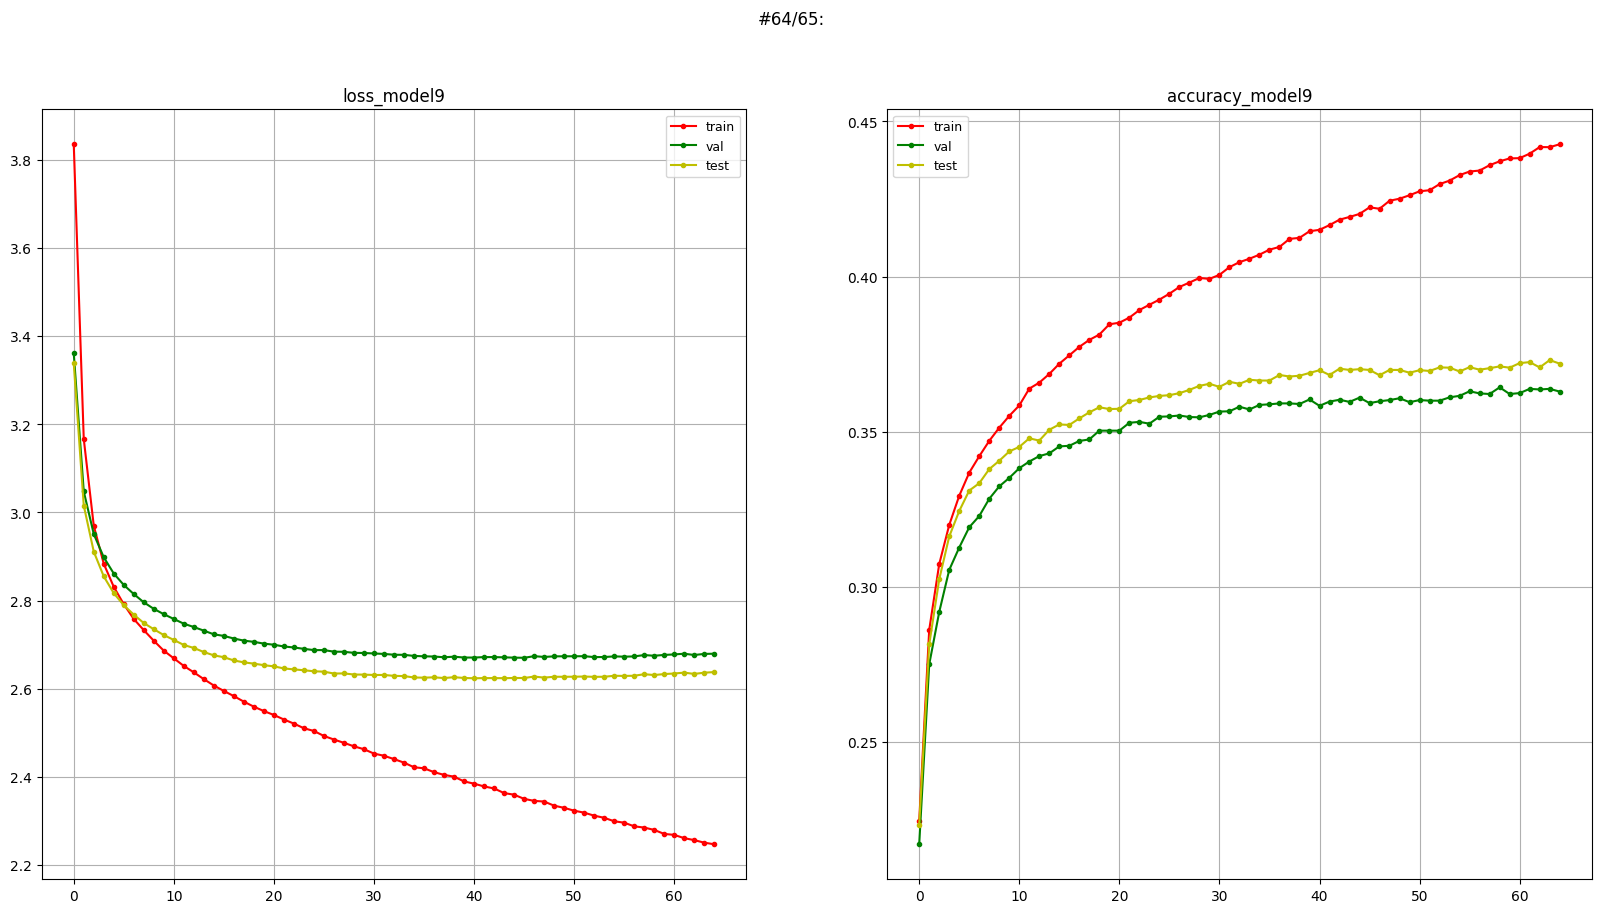

100%|███████████████████████████████████████████| 65/65 [02:38<00:00,  2.44s/it]


0:	learn: 0.1719154	test: 0.1664110	best: 0.1664110 (0)	total: 153ms	remaining: 5m 5s
10:	learn: 0.2085850	test: 0.2016871	best: 0.2017830 (7)	total: 1.86s	remaining: 5m 35s
20:	learn: 0.2452545	test: 0.2358129	best: 0.2358129 (20)	total: 5.08s	remaining: 7m 58s
30:	learn: 0.2609529	test: 0.2488497	best: 0.2488497 (30)	total: 8.4s	remaining: 8m 53s
40:	learn: 0.2727447	test: 0.2618865	best: 0.2618865 (40)	total: 11.8s	remaining: 9m 25s
50:	learn: 0.2842249	test: 0.2707055	best: 0.2707055 (50)	total: 15.3s	remaining: 9m 44s
60:	learn: 0.2952737	test: 0.2781825	best: 0.2781825 (60)	total: 18.8s	remaining: 9m 59s
70:	learn: 0.3039018	test: 0.2829755	best: 0.2829755 (70)	total: 22.4s	remaining: 10m 8s
80:	learn: 0.3126019	test: 0.2926572	best: 0.2926572 (80)	total: 26s	remaining: 10m 15s
90:	learn: 0.3221647	test: 0.2996549	best: 0.2996549 (90)	total: 29.5s	remaining: 10m 19s
100:	learn: 0.3297383	test: 0.3031058	best: 0.3031058 (100)	total: 33.1s	remaining: 10m 22s
110:	learn: 0.3369763	t

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.2280941	test: 0.2329371	best: 0.2329371 (0)	total: 123ms	remaining: 4m 5s
10:	learn: 0.3484565	test: 0.3483512	best: 0.3483512 (10)	total: 1.53s	remaining: 4m 36s
20:	learn: 0.3994583	test: 0.4001150	best: 0.4001150 (20)	total: 4.04s	remaining: 6m 21s
30:	learn: 0.4347618	test: 0.4309816	best: 0.4309816 (30)	total: 7.42s	remaining: 7m 51s
40:	learn: 0.4659429	test: 0.4606020	best: 0.4606020 (40)	total: 10.9s	remaining: 8m 41s
50:	learn: 0.4949909	test: 0.4851419	best: 0.4851419 (50)	total: 14.5s	remaining: 9m 12s
60:	learn: 0.5203001	test: 0.5058474	best: 0.5058474 (60)	total: 18s	remaining: 9m 31s
70:	learn: 0.5422299	test: 0.5248275	best: 0.5248275 (70)	total: 21.5s	remaining: 9m 45s
80:	learn: 0.5610440	test: 0.5421779	best: 0.5421779 (80)	total: 25.1s	remaining: 9m 54s
90:	learn: 0.5777011	test: 0.5570360	best: 0.5570360 (90)	total: 28.7s	remaining: 10m 1s
100:	learn: 0.5956524	test: 0.5707439	best: 0.5707439 (100)	total: 32.2s	remaining: 10m 5s
110:	learn: 0.6099128	te

 33%|██████████████▋                             | 1/3 [11:48<23:36, 708.03s/it]

0:	learn: 0.3143994	test: 0.3134586	best: 0.3134586 (0)	total: 152ms	remaining: 5m 4s
10:	learn: 0.3474020	test: 0.3466258	best: 0.3645514 (2)	total: 1.74s	remaining: 5m 13s
20:	learn: 0.4085179	test: 0.4010736	best: 0.4010736 (20)	total: 4.55s	remaining: 7m 8s
30:	learn: 0.4414725	test: 0.4324195	best: 0.4324195 (30)	total: 7.83s	remaining: 8m 17s
40:	learn: 0.4767999	test: 0.4593558	best: 0.4593558 (40)	total: 11.3s	remaining: 9m 2s
50:	learn: 0.5065670	test: 0.4815951	best: 0.4815951 (50)	total: 14.9s	remaining: 9m 29s
60:	learn: 0.5316365	test: 0.5079563	best: 0.5079563 (60)	total: 18.4s	remaining: 9m 44s
70:	learn: 0.5551481	test: 0.5305790	best: 0.5305790 (70)	total: 22s	remaining: 9m 57s
80:	learn: 0.5762391	test: 0.5449578	best: 0.5449578 (80)	total: 25.5s	remaining: 10m 5s
90:	learn: 0.5951011	test: 0.5575153	best: 0.5575153 (90)	total: 29.1s	remaining: 10m 10s
100:	learn: 0.6112549	test: 0.5712232	best: 0.5712232 (100)	total: 32.7s	remaining: 10m 15s
110:	learn: 0.6261145	tes

 67%|█████████████████████████████▎              | 2/3 [23:34<11:47, 707.22s/it]

0:	learn: 0.2389033	test: 0.2308282	best: 0.2308282 (0)	total: 118ms	remaining: 3m 55s
10:	learn: 0.3404036	test: 0.3396281	best: 0.3396281 (10)	total: 1.9s	remaining: 5m 43s
20:	learn: 0.4015674	test: 0.3986771	best: 0.3986771 (20)	total: 4.46s	remaining: 7m
30:	learn: 0.4311667	test: 0.4229294	best: 0.4229294 (30)	total: 7.83s	remaining: 8m 17s
40:	learn: 0.4665660	test: 0.4546587	best: 0.4546587 (40)	total: 11.3s	remaining: 9m
50:	learn: 0.4951826	test: 0.4815951	best: 0.4815951 (50)	total: 14.8s	remaining: 9m 26s
60:	learn: 0.5231521	test: 0.5044095	best: 0.5044095 (60)	total: 18.3s	remaining: 9m 41s
70:	learn: 0.5468795	test: 0.5249233	best: 0.5249233 (70)	total: 21.9s	remaining: 9m 53s
80:	learn: 0.5669159	test: 0.5424655	best: 0.5424655 (80)	total: 25.3s	remaining: 10m
90:	learn: 0.5850110	test: 0.5565567	best: 0.5565567 (90)	total: 28.9s	remaining: 10m 5s
100:	learn: 0.6025309	test: 0.5691143	best: 0.5691143 (100)	total: 32.4s	remaining: 10m 9s
110:	learn: 0.6172946	test: 0.579

100%|████████████████████████████████████████████| 3/3 [35:23<00:00, 707.76s/it]


0:	learn: 0.2602100	test: 0.2682132	best: 0.2682132 (0)	total: 149ms	remaining: 4m 57s
10:	learn: 0.3358738	test: 0.3359854	best: 0.3743290 (2)	total: 1.94s	remaining: 5m 50s
20:	learn: 0.4053063	test: 0.4002109	best: 0.4002109 (20)	total: 4.64s	remaining: 7m 17s
30:	learn: 0.4407775	test: 0.4315567	best: 0.4315567 (30)	total: 8.05s	remaining: 8m 31s
40:	learn: 0.4790528	test: 0.4634778	best: 0.4634778 (40)	total: 11.6s	remaining: 9m 13s
50:	learn: 0.5087719	test: 0.4900307	best: 0.4900307 (50)	total: 15.1s	remaining: 9m 37s
60:	learn: 0.5352315	test: 0.5149540	best: 0.5149540 (60)	total: 18.6s	remaining: 9m 52s
70:	learn: 0.5588151	test: 0.5368098	best: 0.5368098 (70)	total: 22.1s	remaining: 10m 1s
80:	learn: 0.5797622	test: 0.5552147	best: 0.5552147 (80)	total: 25.7s	remaining: 10m 8s
90:	learn: 0.5967549	test: 0.5673888	best: 0.5673888 (90)	total: 29.2s	remaining: 10m 12s
100:	learn: 0.6154252	test: 0.5831097	best: 0.5831097 (100)	total: 32.7s	remaining: 10m 15s
110:	learn: 0.630380

In [76]:
dataset_folder = 'helena'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder)
results_models_learning = LearnNModels(9, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=3)

In [77]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.3713957055214724
distill_0 : 0.38266871165644173 ---------> 0.3672546012269939
model_1_metric : 0.3679447852760736
distill_1 : 0.38266871165644173 ---------> 0.3677147239263804
model_2_metric : 0.37308282208588955
distill_2 : 0.38266871165644173 ---------> 0.3667944785276074
averaged ensembles accuracy :  0.3711912065439673


In [78]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 35,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_numerical' : 54,
    'd_out' : 4,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.3612955930153278,
    'd_token' : 62,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 6,
    'prenormalization' : False,
    'residual_dropout' : 0.04768041259762395,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0009938085964612058,
    'weight_decay' : 1.219557287938157e-05
}

catboost_params = {
    'bagging_temperature' : 0.1775789113135668,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.333715101902845,
    'leaf_estimation_iterations' : 3,
    'learning_rate' : 0.04816591530865447,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 1,
    'eval_metric': 'Accuracy'
}

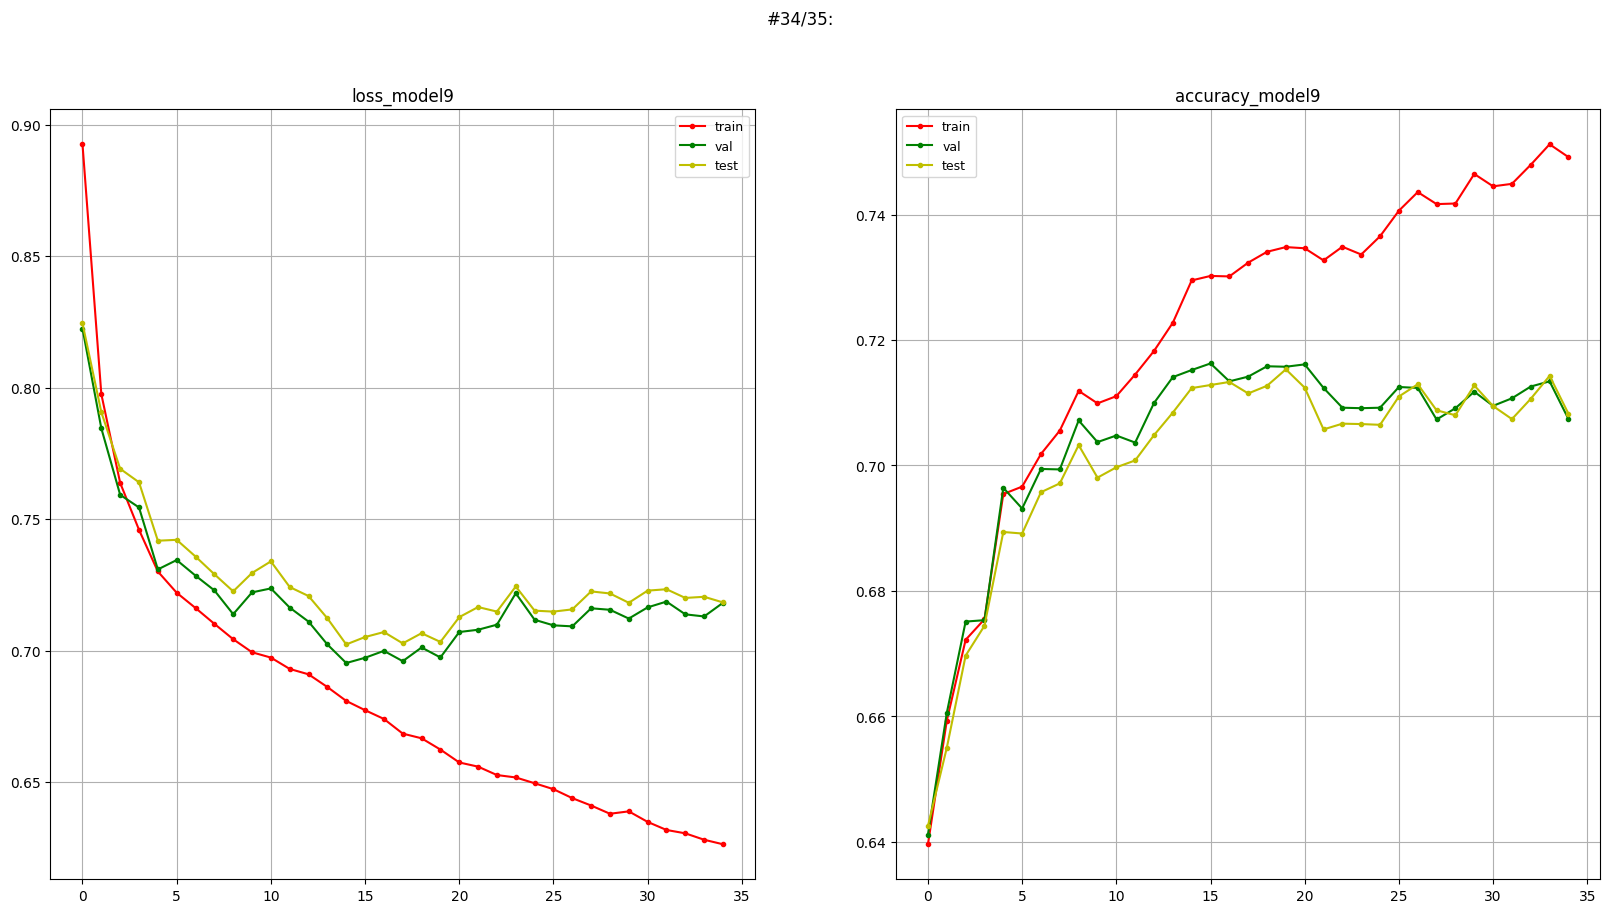

100%|███████████████████████████████████████████| 35/35 [03:29<00:00,  6.00s/it]


0:	learn: 0.6486527	test: 0.6512166	best: 0.6512166 (0)	total: 39.5ms	remaining: 1m 18s
10:	learn: 0.6818504	test: 0.6703986	best: 0.6703986 (10)	total: 418ms	remaining: 1m 15s
20:	learn: 0.6928230	test: 0.6785341	best: 0.6791312 (19)	total: 799ms	remaining: 1m 15s
30:	learn: 0.7022468	test: 0.6848037	best: 0.6848037 (30)	total: 1.19s	remaining: 1m 15s
40:	learn: 0.7106815	test: 0.6921182	best: 0.6921182 (40)	total: 1.57s	remaining: 1m 14s
50:	learn: 0.7180899	test: 0.6965965	best: 0.6965965 (50)	total: 1.92s	remaining: 1m 13s
60:	learn: 0.7238374	test: 0.7012987	best: 0.7012987 (60)	total: 2.27s	remaining: 1m 12s
70:	learn: 0.7283347	test: 0.7059263	best: 0.7059263 (70)	total: 2.61s	remaining: 1m 11s
80:	learn: 0.7329813	test: 0.7080908	best: 0.7080908 (79)	total: 2.94s	remaining: 1m 9s
90:	learn: 0.7373666	test: 0.7093596	best: 0.7103299 (89)	total: 3.27s	remaining: 1m 8s
100:	learn: 0.7416772	test: 0.7113748	best: 0.7114495 (98)	total: 3.63s	remaining: 1m 8s
110:	learn: 0.7455027	te

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7596850	test: 0.7552620	best: 0.7552620 (0)	total: 38.1ms	remaining: 1m 16s
10:	learn: 0.7977346	test: 0.7935513	best: 0.7935513 (10)	total: 421ms	remaining: 1m 16s
20:	learn: 0.8129992	test: 0.8052694	best: 0.8052694 (20)	total: 803ms	remaining: 1m 15s
30:	learn: 0.8232627	test: 0.8149724	best: 0.8149724 (30)	total: 1.15s	remaining: 1m 13s
40:	learn: 0.8352616	test: 0.8228094	best: 0.8229587 (39)	total: 1.52s	remaining: 1m 12s
50:	learn: 0.8447973	test: 0.8298253	best: 0.8301239 (49)	total: 1.88s	remaining: 1m 11s
60:	learn: 0.8525789	test: 0.8357217	best: 0.8357217 (60)	total: 2.23s	remaining: 1m 11s
70:	learn: 0.8583078	test: 0.8422153	best: 0.8422153 (70)	total: 2.58s	remaining: 1m 10s
80:	learn: 0.8655856	test: 0.8471414	best: 0.8471414 (80)	total: 2.93s	remaining: 1m 9s
90:	learn: 0.8708106	test: 0.8507240	best: 0.8507240 (90)	total: 3.27s	remaining: 1m 8s
100:	learn: 0.8750840	test: 0.8544559	best: 0.8544559 (100)	total: 3.62s	remaining: 1m 8s
110:	learn: 0.8798052	t

 33%|███████████████                              | 1/3 [01:13<02:27, 73.59s/it]

0:	learn: 0.7643316	test: 0.7565308	best: 0.7565308 (0)	total: 39.4ms	remaining: 1m 18s
10:	learn: 0.8080540	test: 0.7969846	best: 0.7969846 (10)	total: 419ms	remaining: 1m 15s
20:	learn: 0.8239904	test: 0.8134796	best: 0.8134796 (20)	total: 790ms	remaining: 1m 14s
30:	learn: 0.8365306	test: 0.8250485	best: 0.8250485 (30)	total: 1.15s	remaining: 1m 13s
40:	learn: 0.8458983	test: 0.8310196	best: 0.8310196 (40)	total: 1.52s	remaining: 1m 12s
50:	learn: 0.8554527	test: 0.8366174	best: 0.8366174 (50)	total: 1.88s	remaining: 1m 11s
60:	learn: 0.8666306	test: 0.8430363	best: 0.8430363 (60)	total: 2.23s	remaining: 1m 10s
70:	learn: 0.8735165	test: 0.8501269	best: 0.8501269 (70)	total: 2.58s	remaining: 1m 10s
80:	learn: 0.8802157	test: 0.8539334	best: 0.8539334 (80)	total: 2.93s	remaining: 1m 9s
90:	learn: 0.8858886	test: 0.8590834	best: 0.8590834 (90)	total: 3.28s	remaining: 1m 8s
100:	learn: 0.8911323	test: 0.8625914	best: 0.8625914 (100)	total: 3.62s	remaining: 1m 8s
110:	learn: 0.8958349	t

 67%|██████████████████████████████               | 2/3 [02:27<01:13, 73.95s/it]

0:	learn: 0.7711988	test: 0.7699657	best: 0.7699657 (0)	total: 39.5ms	remaining: 1m 18s
10:	learn: 0.8124580	test: 0.8026571	best: 0.8026571 (10)	total: 414ms	remaining: 1m 14s
20:	learn: 0.8307457	test: 0.8187789	best: 0.8187789 (20)	total: 791ms	remaining: 1m 14s
30:	learn: 0.8429126	test: 0.8336319	best: 0.8336319 (30)	total: 1.14s	remaining: 1m 12s
40:	learn: 0.8545570	test: 0.8425138	best: 0.8425138 (40)	total: 1.51s	remaining: 1m 12s
50:	learn: 0.8653803	test: 0.8489327	best: 0.8497537 (49)	total: 1.87s	remaining: 1m 11s
60:	learn: 0.8745615	test: 0.8577400	best: 0.8577400 (60)	total: 2.24s	remaining: 1m 11s
70:	learn: 0.8811861	test: 0.8632632	best: 0.8632632 (70)	total: 2.59s	remaining: 1m 10s
80:	learn: 0.8874002	test: 0.8668458	best: 0.8668458 (80)	total: 2.95s	remaining: 1m 9s
90:	learn: 0.8926812	test: 0.8697567	best: 0.8697567 (90)	total: 3.31s	remaining: 1m 9s
100:	learn: 0.8974957	test: 0.8737871	best: 0.8737871 (100)	total: 3.66s	remaining: 1m 8s
110:	learn: 0.9018250	t

100%|█████████████████████████████████████████████| 3/3 [03:42<00:00, 74.09s/it]


0:	learn: 0.7690155	test: 0.7636214	best: 0.7636214 (0)	total: 37.8ms	remaining: 1m 15s
10:	learn: 0.8124394	test: 0.8041499	best: 0.8041499 (10)	total: 416ms	remaining: 1m 15s
20:	learn: 0.8292528	test: 0.8200478	best: 0.8200478 (20)	total: 800ms	remaining: 1m 15s
30:	learn: 0.8432298	test: 0.8319898	best: 0.8319898 (30)	total: 1.16s	remaining: 1m 13s
40:	learn: 0.8531947	test: 0.8393790	best: 0.8396029 (39)	total: 1.53s	remaining: 1m 12s
50:	learn: 0.8636075	test: 0.8464696	best: 0.8464696 (50)	total: 1.88s	remaining: 1m 11s
60:	learn: 0.8717623	test: 0.8521421	best: 0.8521421 (60)	total: 2.24s	remaining: 1m 11s
70:	learn: 0.8800851	test: 0.8607255	best: 0.8607255 (70)	total: 2.6s	remaining: 1m 10s
80:	learn: 0.8866911	test: 0.8654277	best: 0.8654277 (80)	total: 2.96s	remaining: 1m 10s
90:	learn: 0.8924573	test: 0.8690103	best: 0.8690103 (89)	total: 3.31s	remaining: 1m 9s
100:	learn: 0.8978503	test: 0.8719958	best: 0.8722944 (99)	total: 3.66s	remaining: 1m 8s
110:	learn: 0.9024222	te

In [79]:
dataset_folder = 'jannis'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=3)

In [80]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7041261121394876
distill_0 : 0.7210843733205947 ---------> 0.7069325849405864
model_1_metric : 0.7203081148862482
distill_1 : 0.7210843733205947 ---------> 0.7133815011643877
model_2_metric : 0.7117095599211799
distill_2 : 0.7210843733205947 ---------> 0.7102167552397445
averaged ensembles accuracy :  0.713699966163094


In [81]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 60,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_numerical' : 28,
    'd_out' : 4,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.1761114683858605,
    'd_token' : 56,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 2,
    'prenormalization' : False,
    'residual_dropout' : 0.1360218086409219,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0007232915040671186,
    'weight_decay' : 4.897971558114274e-06
}

catboost_params = {
    'bagging_temperature' : 0.2762051354652655,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 5.6958564294846,
    'leaf_estimation_iterations' : 8,
    'learning_rate' : 0.04558033669158746,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

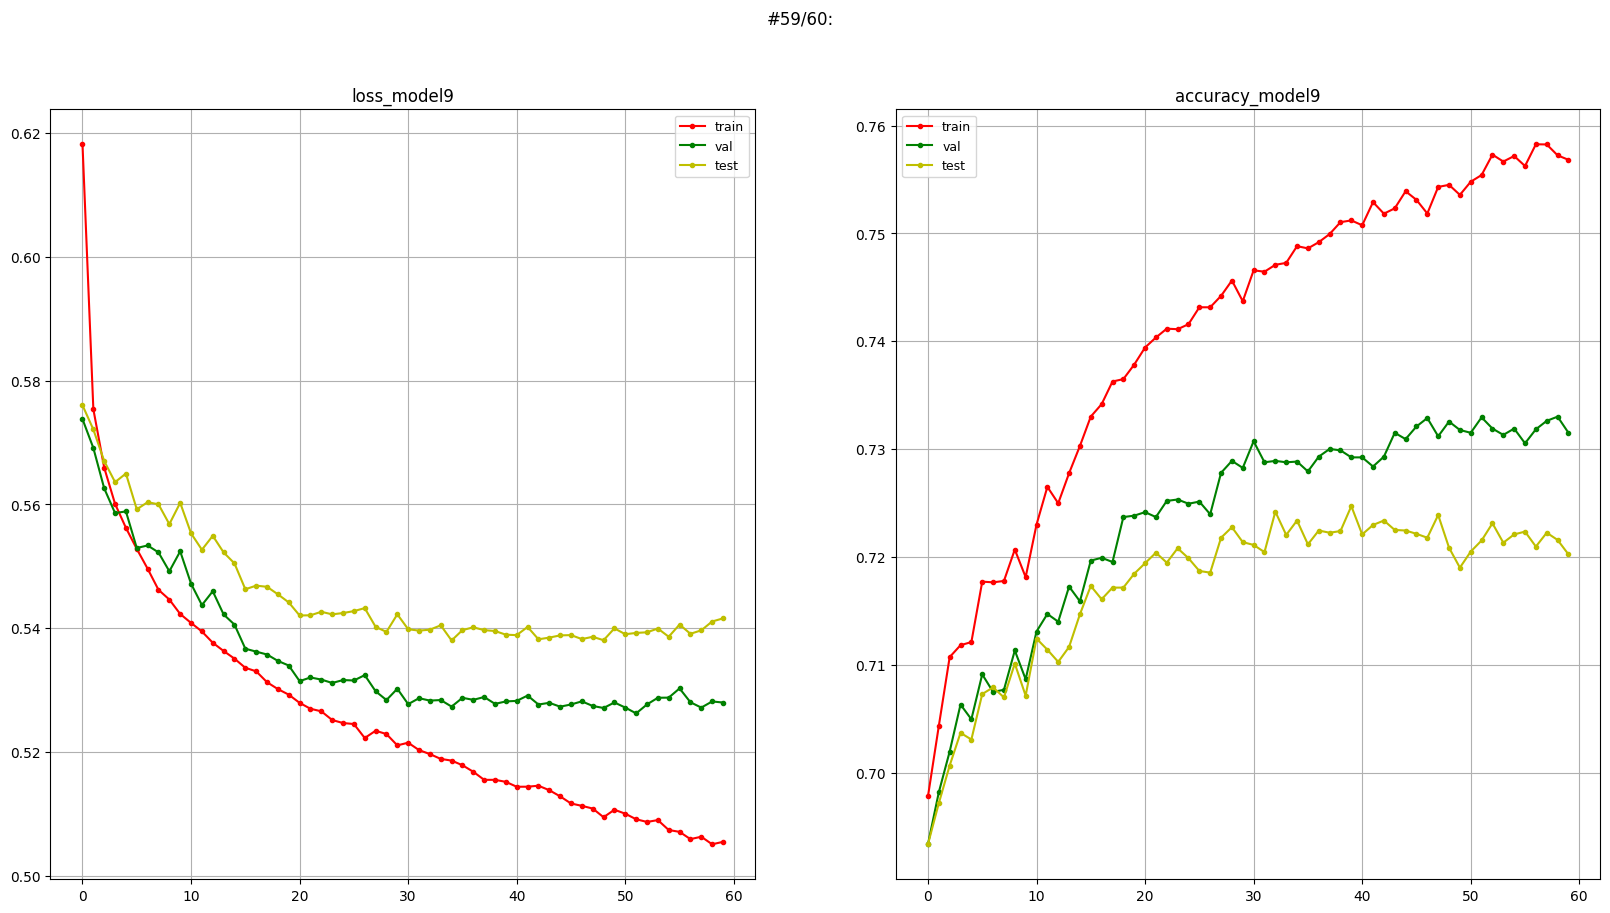

100%|███████████████████████████████████████████| 60/60 [02:14<00:00,  2.25s/it]


0:	learn: 0.6746399	test: 0.6695563	best: 0.6695563 (0)	total: 13.8ms	remaining: 27.6s
10:	learn: 0.6896832	test: 0.6826237	best: 0.6826237 (10)	total: 96ms	remaining: 17.4s
20:	learn: 0.7000892	test: 0.6944161	best: 0.6944161 (20)	total: 175ms	remaining: 16.5s
30:	learn: 0.7083121	test: 0.6998980	best: 0.6998980 (30)	total: 258ms	remaining: 16.4s
40:	learn: 0.7131884	test: 0.7018103	best: 0.7018103 (39)	total: 340ms	remaining: 16.3s
50:	learn: 0.7177779	test: 0.7056986	best: 0.7057624 (49)	total: 422ms	remaining: 16.1s
60:	learn: 0.7231642	test: 0.7083758	best: 0.7083758 (60)	total: 505ms	remaining: 16s
70:	learn: 0.7276900	test: 0.7113717	best: 0.7113717 (70)	total: 588ms	remaining: 16s
80:	learn: 0.7309090	test: 0.7130928	best: 0.7134115 (79)	total: 671ms	remaining: 15.9s
90:	learn: 0.7348770	test: 0.7135390	best: 0.7135390 (90)	total: 754ms	remaining: 15.8s
100:	learn: 0.7371717	test: 0.7132203	best: 0.7141764 (95)	total: 837ms	remaining: 15.7s
110:	learn: 0.7404545	test: 0.7159612

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7785728	test: 0.7719276	best: 0.7719276 (0)	total: 9.59ms	remaining: 19.2s
10:	learn: 0.8045321	test: 0.8009944	best: 0.8013768 (9)	total: 93.5ms	remaining: 16.9s
20:	learn: 0.8208981	test: 0.8155278	best: 0.8155278 (20)	total: 177ms	remaining: 16.6s
30:	learn: 0.8347622	test: 0.8265553	best: 0.8265553 (30)	total: 263ms	remaining: 16.7s
40:	learn: 0.8446743	test: 0.8361168	best: 0.8361168 (40)	total: 350ms	remaining: 16.7s
50:	learn: 0.8535824	test: 0.8431285	best: 0.8431285 (50)	total: 438ms	remaining: 16.7s
60:	learn: 0.8611837	test: 0.8508414	best: 0.8508414 (60)	total: 525ms	remaining: 16.7s
70:	learn: 0.8666975	test: 0.8549847	best: 0.8549847 (70)	total: 610ms	remaining: 16.6s
80:	learn: 0.8727531	test: 0.8607853	best: 0.8607853 (80)	total: 696ms	remaining: 16.5s
90:	learn: 0.8774382	test: 0.8646736	best: 0.8646736 (90)	total: 784ms	remaining: 16.4s
100:	learn: 0.8804500	test: 0.8666497	best: 0.8667772 (99)	total: 871ms	remaining: 16.4s
110:	learn: 0.8849758	test: 0.87

 33%|███████████████                              | 1/3 [00:17<00:34, 17.20s/it]

0:	learn: 0.7755131	test: 0.7646609	best: 0.7646609 (0)	total: 9.1ms	remaining: 18.2s
10:	learn: 0.8008828	test: 0.7879908	best: 0.7879908 (10)	total: 87.9ms	remaining: 15.9s
20:	learn: 0.8161015	test: 0.8035441	best: 0.8035441 (20)	total: 170ms	remaining: 16s
30:	learn: 0.8309695	test: 0.8174401	best: 0.8174401 (30)	total: 253ms	remaining: 16s
40:	learn: 0.8413278	test: 0.8271290	best: 0.8271290 (40)	total: 336ms	remaining: 16s
50:	learn: 0.8506661	test: 0.8369454	best: 0.8369454 (50)	total: 417ms	remaining: 16s
60:	learn: 0.8579328	test: 0.8445946	best: 0.8445946 (60)	total: 500ms	remaining: 15.9s
70:	learn: 0.8645621	test: 0.8505227	best: 0.8505227 (70)	total: 583ms	remaining: 15.8s
80:	learn: 0.8701715	test: 0.8551759	best: 0.8553034 (79)	total: 665ms	remaining: 15.8s
90:	learn: 0.8751434	test: 0.8604666	best: 0.8604666 (90)	total: 748ms	remaining: 15.7s
100:	learn: 0.8784899	test: 0.8635900	best: 0.8635900 (100)	total: 831ms	remaining: 15.6s
110:	learn: 0.8820914	test: 0.8685620	b

 67%|██████████████████████████████               | 2/3 [00:34<00:17, 17.17s/it]

0:	learn: 0.7803257	test: 0.7740311	best: 0.7740311 (0)	total: 9.31ms	remaining: 18.6s
10:	learn: 0.8042293	test: 0.8001657	best: 0.8001657 (10)	total: 90.8ms	remaining: 16.4s
20:	learn: 0.8197508	test: 0.8124044	best: 0.8124044 (20)	total: 172ms	remaining: 16.2s
30:	learn: 0.8314476	test: 0.8231770	best: 0.8231770 (30)	total: 254ms	remaining: 16.2s
40:	learn: 0.8414234	test: 0.8333121	best: 0.8333121 (40)	total: 336ms	remaining: 16.1s
50:	learn: 0.8499171	test: 0.8415987	best: 0.8418536 (49)	total: 417ms	remaining: 15.9s
60:	learn: 0.8568332	test: 0.8473355	best: 0.8474630 (59)	total: 500ms	remaining: 15.9s
70:	learn: 0.8630004	test: 0.8531362	best: 0.8531362 (70)	total: 582ms	remaining: 15.8s
80:	learn: 0.8682114	test: 0.8571520	best: 0.8571520 (80)	total: 666ms	remaining: 15.8s
90:	learn: 0.8729762	test: 0.8614227	best: 0.8614227 (89)	total: 750ms	remaining: 15.7s
100:	learn: 0.8769601	test: 0.8656298	best: 0.8656298 (100)	total: 834ms	remaining: 15.7s
110:	learn: 0.8812149	test: 0.

100%|█████████████████████████████████████████████| 3/3 [00:51<00:00, 17.20s/it]


0:	learn: 0.7820309	test: 0.7748598	best: 0.7748598 (0)	total: 8.81ms	remaining: 17.6s
10:	learn: 0.8075280	test: 0.7970423	best: 0.7970423 (10)	total: 88.7ms	remaining: 16s
20:	learn: 0.8236072	test: 0.8157190	best: 0.8157190 (20)	total: 170ms	remaining: 16.1s
30:	learn: 0.8363399	test: 0.8272565	best: 0.8272565 (30)	total: 253ms	remaining: 16.1s
40:	learn: 0.8466662	test: 0.8393039	best: 0.8393039 (40)	total: 337ms	remaining: 16.1s
50:	learn: 0.8563074	test: 0.8473355	best: 0.8473993 (49)	total: 421ms	remaining: 16.1s
60:	learn: 0.8642274	test: 0.8536461	best: 0.8536461 (60)	total: 503ms	remaining: 16s
70:	learn: 0.8705221	test: 0.8610403	best: 0.8610403 (70)	total: 586ms	remaining: 15.9s
80:	learn: 0.8761633	test: 0.8646736	best: 0.8646736 (80)	total: 671ms	remaining: 15.9s
90:	learn: 0.8813584	test: 0.8684982	best: 0.8684982 (89)	total: 755ms	remaining: 15.8s
100:	learn: 0.8851989	test: 0.8716854	best: 0.8716854 (100)	total: 838ms	remaining: 15.7s
110:	learn: 0.8887366	test: 0.8745

In [82]:
dataset_folder = 'higgs_small'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=3)

In [83]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7217746047934727
distill_0 : 0.7250892401835798 ---------> 0.7229474757776645
model_1_metric : 0.7197348291687914
distill_1 : 0.7250892401835798 ---------> 0.7201427842937277
model_2_metric : 0.7220295767465579
distill_2 : 0.7250892401835798 ---------> 0.723661397246303
averaged ensembles accuracy :  0.7239163691993881


In [84]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 100,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_numerical' : 8,
    'd_out' : 1,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.0535237809492843,
    'd_token' : 56,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 4,
    'prenormalization' : False,
    'residual_dropout' : 0.1235366792955364,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0008810479866449889,
    'weight_decay' : 0.0001860967600352141
}

catboost_params = {
    'bagging_temperature' : 0.004350736313860622,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.157639995907031,
    'leaf_estimation_iterations' : 4,
    'learning_rate' : 0.1021076879315874,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

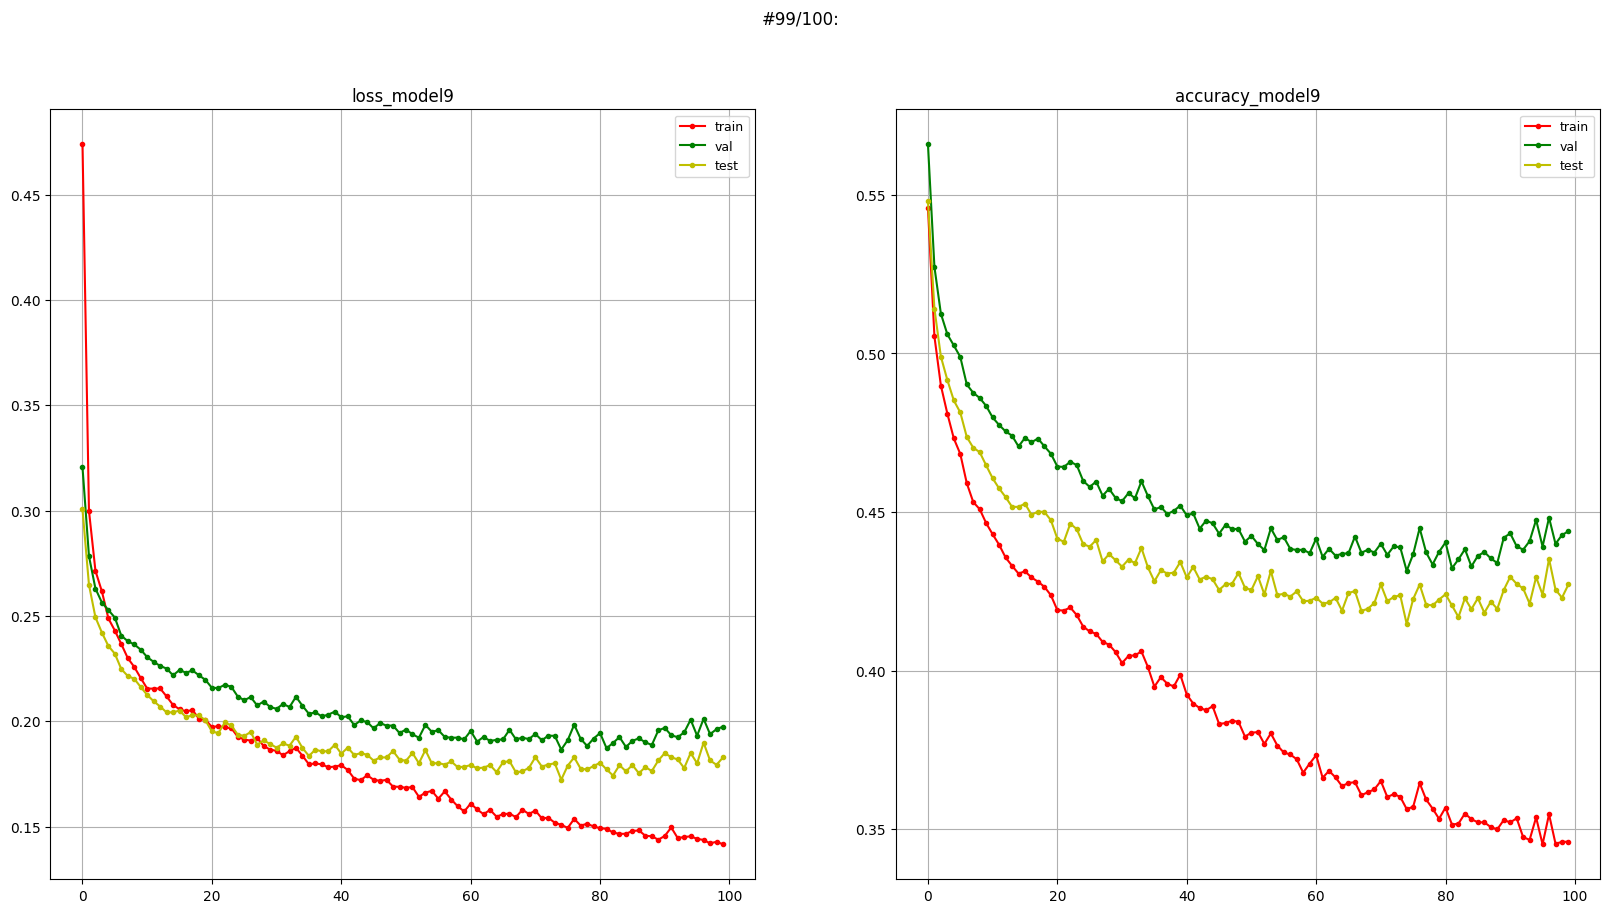

100%|█████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


0:	learn: 0.9361596	test: 0.9365706	best: 0.9365706 (0)	total: 115ms	remaining: 3m 48s
10:	learn: 0.5903575	test: 0.6043515	best: 0.6043515 (10)	total: 802ms	remaining: 2m 24s
20:	learn: 0.4907550	test: 0.5116647	best: 0.5116647 (20)	total: 1.46s	remaining: 2m 17s
30:	learn: 0.4548279	test: 0.4788678	best: 0.4788678 (30)	total: 2.11s	remaining: 2m 13s
40:	learn: 0.4322337	test: 0.4612566	best: 0.4612566 (40)	total: 2.76s	remaining: 2m 12s
50:	learn: 0.4180322	test: 0.4510834	best: 0.4510834 (50)	total: 3.42s	remaining: 2m 10s
60:	learn: 0.4077928	test: 0.4452423	best: 0.4452423 (60)	total: 4.03s	remaining: 2m 8s
70:	learn: 0.3968504	test: 0.4364781	best: 0.4364781 (70)	total: 4.69s	remaining: 2m 7s
80:	learn: 0.3911905	test: 0.4334863	best: 0.4334863 (80)	total: 5.13s	remaining: 2m 1s
90:	learn: 0.3870045	test: 0.4308548	best: 0.4308548 (90)	total: 5.56s	remaining: 1m 56s
100:	learn: 0.3827532	test: 0.4287226	best: 0.4287226 (100)	total: 6.04s	remaining: 1m 53s
110:	learn: 0.3789732	te

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9027995	test: 0.8936450	best: 0.8936450 (0)	total: 68.8ms	remaining: 2m 17s
10:	learn: 0.4990883	test: 0.4957026	best: 0.4957026 (10)	total: 738ms	remaining: 2m 13s
20:	learn: 0.3562091	test: 0.3514494	best: 0.3514494 (20)	total: 1.4s	remaining: 2m 12s
30:	learn: 0.3022283	test: 0.2975800	best: 0.2975800 (30)	total: 2.07s	remaining: 2m 11s
40:	learn: 0.2767380	test: 0.2733927	best: 0.2733927 (40)	total: 2.73s	remaining: 2m 10s
50:	learn: 0.2580208	test: 0.2576639	best: 0.2576639 (50)	total: 3.35s	remaining: 2m 7s
60:	learn: 0.2409892	test: 0.2426789	best: 0.2426789 (60)	total: 4.02s	remaining: 2m 7s
70:	learn: 0.2272922	test: 0.2311238	best: 0.2311238 (70)	total: 4.69s	remaining: 2m 7s
80:	learn: 0.2154725	test: 0.2222300	best: 0.2222300 (80)	total: 5.36s	remaining: 2m 7s
90:	learn: 0.2085382	test: 0.2168127	best: 0.2168127 (90)	total: 5.98s	remaining: 2m 5s
100:	learn: 0.2025057	test: 0.2118532	best: 0.2118532 (100)	total: 6.52s	remaining: 2m 2s
110:	learn: 0.1969128	test:

 33%|███████████████                              | 1/3 [00:44<01:28, 44.19s/it]

1990:	learn: 0.1188734	test: 0.1611310	best: 0.1611286 (1986)	total: 43.7s	remaining: 198ms
1999:	learn: 0.1188716	test: 0.1611355	best: 0.1611286 (1986)	total: 43.8s	remaining: 0us
bestTest = 0.1611285773
bestIteration = 1986
Shrink model to first 1987 iterations.
0:	learn: 0.8875015	test: 0.8781518	best: 0.8781518 (0)	total: 69.3ms	remaining: 2m 18s
10:	learn: 0.4971129	test: 0.4921243	best: 0.4921243 (10)	total: 742ms	remaining: 2m 14s
20:	learn: 0.3689902	test: 0.3690992	best: 0.3690992 (20)	total: 1.41s	remaining: 2m 13s
30:	learn: 0.3125329	test: 0.3150860	best: 0.3150860 (30)	total: 2.08s	remaining: 2m 12s
40:	learn: 0.2825215	test: 0.2879462	best: 0.2879462 (40)	total: 2.75s	remaining: 2m 11s
50:	learn: 0.2684520	test: 0.2755030	best: 0.2755030 (50)	total: 3.24s	remaining: 2m 3s
60:	learn: 0.2507206	test: 0.2598889	best: 0.2598889 (60)	total: 3.86s	remaining: 2m 2s
70:	learn: 0.2347189	test: 0.2487288	best: 0.2487288 (70)	total: 4.53s	remaining: 2m 3s
80:	learn: 0.2245119	test:

 67%|██████████████████████████████               | 2/3 [01:34<00:47, 47.90s/it]

1999:	learn: 0.1235949	test: 0.1755800	best: 0.1755624 (1960)	total: 50.1s	remaining: 0us
bestTest = 0.1755623653
bestIteration = 1960
Shrink model to first 1961 iterations.
0:	learn: 0.8995740	test: 0.8919753	best: 0.8919753 (0)	total: 68ms	remaining: 2m 16s
10:	learn: 0.4949535	test: 0.4936793	best: 0.4936793 (10)	total: 739ms	remaining: 2m 13s
20:	learn: 0.3555174	test: 0.3552671	best: 0.3552671 (20)	total: 1.41s	remaining: 2m 13s
30:	learn: 0.2989407	test: 0.2987708	best: 0.2987708 (30)	total: 2.08s	remaining: 2m 12s
40:	learn: 0.2698439	test: 0.2716659	best: 0.2716659 (40)	total: 2.75s	remaining: 2m 11s
50:	learn: 0.2567399	test: 0.2612846	best: 0.2612846 (50)	total: 3.32s	remaining: 2m 6s
60:	learn: 0.2411464	test: 0.2479921	best: 0.2479921 (60)	total: 3.93s	remaining: 2m 5s
70:	learn: 0.2286296	test: 0.2370762	best: 0.2370762 (70)	total: 4.55s	remaining: 2m 3s
80:	learn: 0.2158317	test: 0.2266221	best: 0.2266221 (80)	total: 5.22s	remaining: 2m 3s
90:	learn: 0.2050542	test: 0.217

100%|█████████████████████████████████████████████| 3/3 [02:26<00:00, 48.85s/it]

1999:	learn: 0.1059042	test: 0.1561551	best: 0.1561551 (1893)	total: 51.5s	remaining: 0us
bestTest = 0.1561550719
bestIteration = 1893
Shrink model to first 1894 iterations.


0:	learn: 0.8926328	test: 0.8827490	best: 0.8827490 (0)	total: 68.8ms	remaining: 2m 17s
10:	learn: 0.4853903	test: 0.4815815	best: 0.4815815 (10)	total: 745ms	remaining: 2m 14s
20:	learn: 0.3516513	test: 0.3477447	best: 0.3477447 (20)	total: 1.42s	remaining: 2m 13s
30:	learn: 0.2964257	test: 0.2932507	best: 0.2932507 (30)	total: 2.08s	remaining: 2m 12s
40:	learn: 0.2688064	test: 0.2675803	best: 0.2675803 (40)	total: 2.75s	remaining: 2m 11s
50:	learn: 0.2516374	test: 0.2522870	best: 0.2522870 (50)	total: 3.42s	remaining: 2m 10s
60:	learn: 0.2401406	test: 0.2426285	best: 0.2426285 (60)	total: 3.86s	remaining: 2m 2s
70:	learn: 0.2273586	test: 0.2308810	best: 0.2308810 (70)	total: 4.36s	remaining: 1m 58s
80:	learn: 0.2129654	test: 0.2184466	best: 0.2184466 (80)	total: 5.03s	remaining: 1m 59s
90:	learn: 0.2045455	test: 0.2119857	best: 0.2119857 (90)	total: 5.59s	remaining: 1m 57s
100:	learn: 0.2027015	test: 0.2104060	best: 0.2104060 (100)	total: 5.79s	remaining: 1m 48s
110:	learn: 0.1990278

In [85]:
dataset_folder = 'california_housing'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt', regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=3, ensemble_size=3, regression=True)

In [86]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 0.4835531454003427
distill_0 : 0.45440448463607774 ---------> 0.475047917381435
model_1_metric : 0.4778305349052871
distill_1 : 0.45440448463607774 ---------> 0.46824152840847744
model_2_metric : 0.4851057540129121
distill_2 : 0.45440448463607774 ---------> 0.47159246786576237
averaged ensembles accuracy :  0.4684376977396723


In [87]:
train_params = {
    'batch_size' : 1024,
    'eval_batch_size' : 1024,
    'num_epochs' : 70,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_numerical' : 90,
    'd_out' : 1,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.4624591155512257,
    'd_token' : 60,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 5,
    'prenormalization' : False,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0001852525639726797,
    'weight_decay' : 6.735515980199453e-05
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

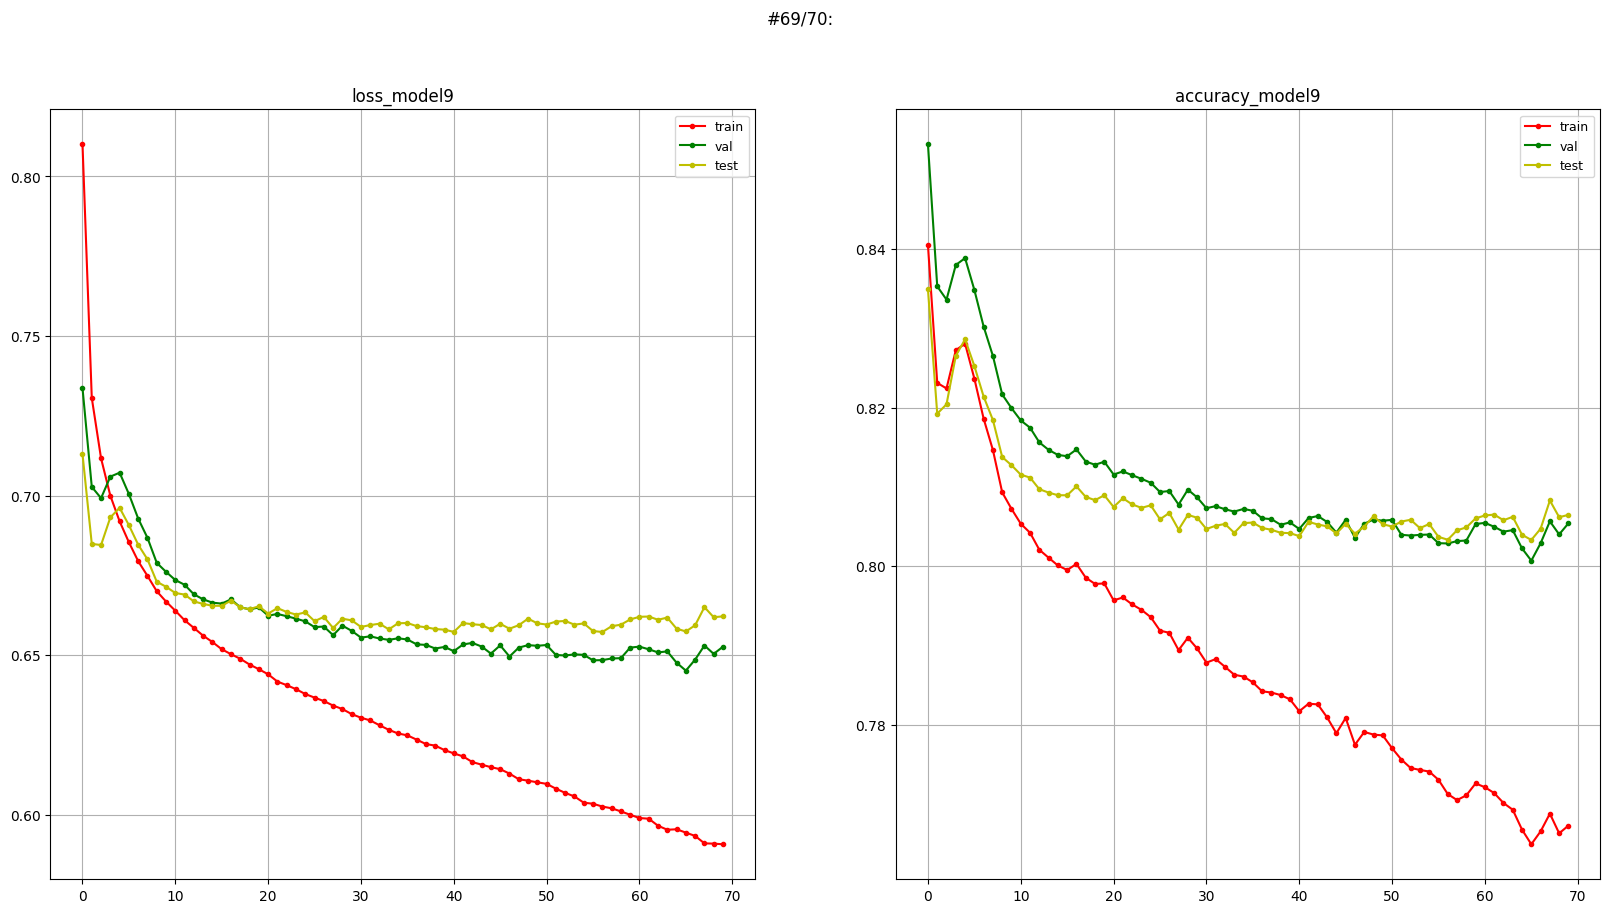

100%|███████████████████████████████████████████| 70/70 [45:19<00:00, 38.85s/it]


0:	learn: 0.9914147	test: 0.9967809	best: 0.9967809 (0)	total: 18.5ms	remaining: 36.9s
10:	learn: 0.9324685	test: 0.9388348	best: 0.9388348 (10)	total: 195ms	remaining: 35.2s
20:	learn: 0.9001344	test: 0.9072233	best: 0.9072233 (20)	total: 374ms	remaining: 35.2s
30:	learn: 0.8800481	test: 0.8877585	best: 0.8877585 (30)	total: 551ms	remaining: 35s
40:	learn: 0.8667816	test: 0.8750099	best: 0.8750099 (40)	total: 728ms	remaining: 34.8s
50:	learn: 0.8572563	test: 0.8662189	best: 0.8662189 (50)	total: 908ms	remaining: 34.7s
60:	learn: 0.8499228	test: 0.8598097	best: 0.8598097 (60)	total: 1.09s	remaining: 34.5s
70:	learn: 0.8441134	test: 0.8547046	best: 0.8547046 (70)	total: 1.27s	remaining: 34.5s
80:	learn: 0.8388913	test: 0.8506284	best: 0.8506284 (80)	total: 1.45s	remaining: 34.3s
90:	learn: 0.8344994	test: 0.8473707	best: 0.8473707 (90)	total: 1.63s	remaining: 34.2s
100:	learn: 0.8307917	test: 0.8446539	best: 0.8446539 (100)	total: 1.81s	remaining: 34.1s
110:	learn: 0.8271697	test: 0.842

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.6398527	test: 0.6430842	best: 0.6430842 (0)	total: 17.5ms	remaining: 34.9s
10:	learn: 0.5302311	test: 0.5333890	best: 0.5333890 (10)	total: 183ms	remaining: 33.1s
20:	learn: 0.4640410	test: 0.4670897	best: 0.4670897 (20)	total: 350ms	remaining: 33s
30:	learn: 0.4217244	test: 0.4247909	best: 0.4247909 (30)	total: 520ms	remaining: 33s
40:	learn: 0.3925151	test: 0.3957074	best: 0.3957074 (40)	total: 694ms	remaining: 33.2s
50:	learn: 0.3712113	test: 0.3745237	best: 0.3745237 (50)	total: 872ms	remaining: 33.3s
60:	learn: 0.3548842	test: 0.3584807	best: 0.3584807 (60)	total: 1.05s	remaining: 33.5s
70:	learn: 0.3412774	test: 0.3451425	best: 0.3451425 (70)	total: 1.24s	remaining: 33.6s
80:	learn: 0.3303555	test: 0.3345027	best: 0.3345027 (80)	total: 1.42s	remaining: 33.6s
90:	learn: 0.3211958	test: 0.3255949	best: 0.3255949 (90)	total: 1.6s	remaining: 33.5s
100:	learn: 0.3131951	test: 0.3178415	best: 0.3178415 (100)	total: 1.78s	remaining: 33.4s
110:	learn: 0.3062433	test: 0.311102

 33%|███████████████                              | 1/3 [00:38<01:17, 38.90s/it]

0:	learn: 0.6518378	test: 0.6543307	best: 0.6543307 (0)	total: 17.8ms	remaining: 35.7s
10:	learn: 0.5440815	test: 0.5463294	best: 0.5463294 (10)	total: 189ms	remaining: 34.3s
20:	learn: 0.4796501	test: 0.4818575	best: 0.4818575 (20)	total: 364ms	remaining: 34.3s
30:	learn: 0.4388063	test: 0.4410927	best: 0.4410927 (30)	total: 537ms	remaining: 34.1s
40:	learn: 0.4102395	test: 0.4125357	best: 0.4125357 (40)	total: 716ms	remaining: 34.2s
50:	learn: 0.3896698	test: 0.3920556	best: 0.3920556 (50)	total: 900ms	remaining: 34.4s
60:	learn: 0.3739392	test: 0.3764877	best: 0.3764877 (60)	total: 1.08s	remaining: 34.4s
70:	learn: 0.3615999	test: 0.3644822	best: 0.3644822 (70)	total: 1.27s	remaining: 34.6s
80:	learn: 0.3514573	test: 0.3546397	best: 0.3546397 (80)	total: 1.46s	remaining: 34.7s
90:	learn: 0.3425565	test: 0.3460431	best: 0.3460431 (90)	total: 1.65s	remaining: 34.7s
100:	learn: 0.3352244	test: 0.3389471	best: 0.3389471 (100)	total: 1.84s	remaining: 34.6s
110:	learn: 0.3287585	test: 0.3

 67%|██████████████████████████████               | 2/3 [01:17<00:38, 38.64s/it]

0:	learn: 0.6525014	test: 0.6550931	best: 0.6550931 (0)	total: 18.2ms	remaining: 36.4s
10:	learn: 0.5453676	test: 0.5478273	best: 0.5478273 (10)	total: 190ms	remaining: 34.3s
20:	learn: 0.4807143	test: 0.4829974	best: 0.4829974 (20)	total: 366ms	remaining: 34.5s
30:	learn: 0.4383689	test: 0.4405389	best: 0.4405389 (30)	total: 542ms	remaining: 34.5s
40:	learn: 0.4090292	test: 0.4111957	best: 0.4111957 (40)	total: 722ms	remaining: 34.5s
50:	learn: 0.3875366	test: 0.3898095	best: 0.3898095 (50)	total: 905ms	remaining: 34.6s
60:	learn: 0.3709912	test: 0.3734460	best: 0.3734460 (60)	total: 1.09s	remaining: 34.5s
70:	learn: 0.3580532	test: 0.3606505	best: 0.3606505 (70)	total: 1.27s	remaining: 34.5s
80:	learn: 0.3469986	test: 0.3498388	best: 0.3498388 (80)	total: 1.46s	remaining: 34.5s
90:	learn: 0.3377525	test: 0.3409468	best: 0.3409468 (90)	total: 1.64s	remaining: 34.4s
100:	learn: 0.3298520	test: 0.3333491	best: 0.3333491 (100)	total: 1.82s	remaining: 34.3s
110:	learn: 0.3227379	test: 0.3

100%|█████████████████████████████████████████████| 3/3 [01:56<00:00, 38.83s/it]


0:	learn: 0.6390627	test: 0.6415728	best: 0.6415728 (0)	total: 18.1ms	remaining: 36.2s
10:	learn: 0.5291697	test: 0.5313553	best: 0.5313553 (10)	total: 188ms	remaining: 34.1s
20:	learn: 0.4627090	test: 0.4648068	best: 0.4648068 (20)	total: 359ms	remaining: 33.8s
30:	learn: 0.4198086	test: 0.4218458	best: 0.4218458 (30)	total: 534ms	remaining: 33.9s
40:	learn: 0.3902659	test: 0.3921732	best: 0.3921732 (40)	total: 712ms	remaining: 34s
50:	learn: 0.3684107	test: 0.3704781	best: 0.3704781 (50)	total: 896ms	remaining: 34.2s
60:	learn: 0.3515669	test: 0.3537845	best: 0.3537845 (60)	total: 1.07s	remaining: 34.2s
70:	learn: 0.3381568	test: 0.3405544	best: 0.3405544 (70)	total: 1.26s	remaining: 34.3s
80:	learn: 0.3272367	test: 0.3298800	best: 0.3298800 (80)	total: 1.45s	remaining: 34.2s
90:	learn: 0.3176645	test: 0.3206312	best: 0.3206312 (90)	total: 1.63s	remaining: 34.3s
100:	learn: 0.3099233	test: 0.3131166	best: 0.3131166 (100)	total: 1.82s	remaining: 34.2s
110:	learn: 0.3026328	test: 0.306

In [88]:
dataset_folder = 'year'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt', regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=3, ensemble_size=3, regression=True)

In [89]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 8.938442768732973
distill_0 : 8.886524300635156 ---------> 9.011749443416011
model_1_metric : 8.974322135349416
distill_1 : 8.886524300635156 ---------> 9.00554842083463
model_2_metric : 8.977921373521648
distill_2 : 8.886524300635156 ---------> 9.004719118216192
averaged ensembles accuracy :  8.978835427432921


In [94]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 70,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_numerical' : 128,
    'd_out' : 1000,
    'categories' : None,
    'activation' : 'relu',
    'attention_dropout' : 0.1826903968910185,
    'd_token' : 62,
    'initialization' : 'kaiming',
    'n_heads' : 2,
    'n_layers' : 3,
    'prenormalization' : False,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0001040166440717462,
    'weight_decay' : 0.0002206706981235778
}

catboost_params = {
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

In [97]:
dataset_folder = 'aloi'
metric = accuracy_score

#data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='standard')
#results_models_learning = LearnNModels(6, AutoInt, model_params, optimizer_params, data_model, train_params, metric, file_to_load='autoint.pt')
gc.collect()
torch.cuda.empty_cache()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=3)

Learning rate set to 0.119146
0:	learn: 0.0494792	test: 0.0494792	best: 0.0494792 (0)	total: 7.71s	remaining: 4h 16m 48s
10:	learn: 0.5054253	test: 0.4928241	best: 0.4928241 (10)	total: 1m 16s	remaining: 3h 50m 42s
20:	learn: 0.6959201	test: 0.6759838	best: 0.6759838 (20)	total: 2m 27s	remaining: 3h 51m 3s
30:	learn: 0.7710648	test: 0.7495370	best: 0.7495370 (30)	total: 3m 40s	remaining: 3h 52m 57s
40:	learn: 0.8131366	test: 0.7893519	best: 0.7893519 (40)	total: 4m 54s	remaining: 3h 54m 54s
50:	learn: 0.8368200	test: 0.8118634	best: 0.8118634 (50)	total: 6m 6s	remaining: 3h 53m 24s
60:	learn: 0.8550203	test: 0.8276620	best: 0.8276620 (60)	total: 7m 16s	remaining: 3h 51m 4s
70:	learn: 0.8679687	test: 0.8390625	best: 0.8390625 (70)	total: 8m 23s	remaining: 3h 47m 58s
80:	learn: 0.8780961	test: 0.8491898	best: 0.8491898 (80)	total: 9m 28s	remaining: 3h 44m 39s
90:	learn: 0.8881655	test: 0.8570023	best: 0.8570023 (90)	total: 10m 34s	remaining: 3h 41m 59s
100:	learn: 0.8977720	test: 0.86469

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Learning rate set to 0.119146
0:	learn: 0.0280527	test: 0.0281829	best: 0.0281829 (0)	total: 6.74s	remaining: 3h 44m 33s
10:	learn: 0.4845486	test: 0.4677662	best: 0.4677662 (10)	total: 1m 14s	remaining: 3h 44m 18s
20:	learn: 0.7104601	test: 0.6853009	best: 0.6853009 (20)	total: 2m 25s	remaining: 3h 49m 17s
30:	learn: 0.7901042	test: 0.7651042	best: 0.7651042 (30)	total: 3m 36s	remaining: 3h 48m 59s
40:	learn: 0.8272714	test: 0.8015625	best: 0.8015625 (40)	total: 4m 47s	remaining: 3h 48m 57s
50:	learn: 0.8499132	test: 0.8209491	best: 0.8209491 (50)	total: 5m 58s	remaining: 3h 48m 6s
60:	learn: 0.8675492	test: 0.8364005	best: 0.8364005 (60)	total: 7m 9s	remaining: 3h 47m 29s
70:	learn: 0.8793113	test: 0.8461806	best: 0.8461806 (70)	total: 8m 18s	remaining: 3h 45m 35s
80:	learn: 0.8897569	test: 0.8563657	best: 0.8563657 (80)	total: 9m 28s	remaining: 3h 44m 18s
90:	learn: 0.8989005	test: 0.8637731	best: 0.8637731 (90)	total: 10m 38s	remaining: 3h 43m 9s
100:	learn: 0.9068576	test: 0.87112

 33%|████████████▋                         | 1/3 [3:46:16<7:32:33, 13576.72s/it]

Learning rate set to 0.119146
0:	learn: 0.0283999	test: 0.0285880	best: 0.0285880 (0)	total: 6.77s	remaining: 3h 45m 33s
10:	learn: 0.5012297	test: 0.4847801	best: 0.4847801 (10)	total: 1m 15s	remaining: 3h 46m 41s
20:	learn: 0.7084346	test: 0.6874421	best: 0.6874421 (20)	total: 2m 26s	remaining: 3h 50m 44s
30:	learn: 0.7879485	test: 0.7647569	best: 0.7647569 (30)	total: 3m 38s	remaining: 3h 51m 24s
40:	learn: 0.8315249	test: 0.8039931	best: 0.8039931 (40)	total: 4m 51s	remaining: 3h 52m 27s
50:	learn: 0.8491898	test: 0.8214699	best: 0.8214699 (50)	total: 6m 1s	remaining: 3h 50m 27s
60:	learn: 0.8671730	test: 0.8381944	best: 0.8381944 (60)	total: 7m 12s	remaining: 3h 49m 5s
70:	learn: 0.8792969	test: 0.8484375	best: 0.8484375 (70)	total: 8m 23s	remaining: 3h 47m 51s
80:	learn: 0.8895833	test: 0.8585648	best: 0.8585648 (80)	total: 9m 33s	remaining: 3h 46m 37s
90:	learn: 0.8985388	test: 0.8666088	best: 0.8666088 (90)	total: 10m 43s	remaining: 3h 44m 55s
100:	learn: 0.9051215	test: 0.8712

 67%|█████████████████████████▎            | 2/3 [7:34:07<3:47:11, 13631.83s/it]

Learning rate set to 0.119146
0:	learn: 0.0282263	test: 0.0280671	best: 0.0280671 (0)	total: 6.73s	remaining: 3h 44m 22s
10:	learn: 0.4571759	test: 0.4396991	best: 0.4396991 (10)	total: 1m 13s	remaining: 3h 42m 25s
20:	learn: 0.7220775	test: 0.6984375	best: 0.6984375 (20)	total: 2m 25s	remaining: 3h 48m 45s
30:	learn: 0.7961806	test: 0.7734954	best: 0.7734954 (30)	total: 3m 36s	remaining: 3h 48m 40s
40:	learn: 0.8306424	test: 0.8056134	best: 0.8056134 (40)	total: 4m 47s	remaining: 3h 48m 55s
50:	learn: 0.8549913	test: 0.8277778	best: 0.8277778 (50)	total: 5m 58s	remaining: 3h 48m 25s
60:	learn: 0.8692564	test: 0.8410301	best: 0.8410301 (60)	total: 7m 6s	remaining: 3h 46m 5s
70:	learn: 0.8801649	test: 0.8494213	best: 0.8494792 (69)	total: 8m 16s	remaining: 3h 44m 51s
80:	learn: 0.8905961	test: 0.8579282	best: 0.8579282 (80)	total: 9m 25s	remaining: 3h 43m 13s
90:	learn: 0.8990451	test: 0.8653935	best: 0.8653935 (90)	total: 10m 34s	remaining: 3h 41m 50s
100:	learn: 0.9056279	test: 0.8703

100%|███████████████████████████████████████| 3/3 [11:20:03<00:00, 13601.28s/it]


Learning rate set to 0.119146
0:	learn: 0.0280382	test: 0.0281829	best: 0.0281829 (0)	total: 7.1s	remaining: 3h 56m 32s
10:	learn: 0.4590278	test: 0.4416667	best: 0.4416667 (10)	total: 1m 14s	remaining: 3h 45m 22s
20:	learn: 0.7144676	test: 0.6945023	best: 0.6945023 (20)	total: 2m 26s	remaining: 3h 50m 6s
30:	learn: 0.7917969	test: 0.7697917	best: 0.7697917 (30)	total: 3m 37s	remaining: 3h 50m 7s
40:	learn: 0.8270544	test: 0.8035880	best: 0.8035880 (40)	total: 4m 47s	remaining: 3h 48m 54s
50:	learn: 0.8514178	test: 0.8261574	best: 0.8261574 (50)	total: 6m	remaining: 3h 49m 26s
60:	learn: 0.8663194	test: 0.8391782	best: 0.8391782 (60)	total: 7m 9s	remaining: 3h 47m 18s
70:	learn: 0.8773437	test: 0.8493634	best: 0.8493634 (70)	total: 8m 19s	remaining: 3h 46m 16s
80:	learn: 0.8880642	test: 0.8609954	best: 0.8609954 (80)	total: 9m 28s	remaining: 3h 44m 37s
90:	learn: 0.8980903	test: 0.8699074	best: 0.8699074 (90)	total: 10m 38s	remaining: 3h 43m 12s
100:	learn: 0.9061053	test: 0.8754051	be

In [98]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.9415277777777777
distill_0 : 0.9452777777777778 ---------> 0.9493518518518519
model_1_metric : 0.9400925925925926
distill_1 : 0.9452777777777778 ---------> 0.9488425925925926
model_2_metric : 0.9401388888888889
distill_2 : 0.9452777777777778 ---------> 0.9496296296296296
averaged ensembles accuracy :  0.9510185185185185


In [99]:
a = np.array([0.9415277777777777, 0.9400925925925926, 0.9401388888888889])
b = np.array([0.9493518518518519, 0.9488425925925926, 0.9496296296296296])
a.std(), a.mean(), b.std(), b.mean()

(0.0006659089200737995,
 0.9405864197530863,
 0.00032590605064724453,
 0.9492746913580247)